Rodrigo F. R da Silva

RA: 20.83984-7


Dados:  https://www.kaggle.com/bryanb/abstract-art-gallery


## Lendo as Images

As imagens inicialmente zipadas, serao lidas na sessao do colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/archive.zip","r") as zip_ref:
  zip_ref.extractall("targetdir")

In [3]:
from os import listdir
from matplotlib import image
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Carregando as imagens em um diretório
images = list()
images_path = '/content/targetdir/Abstract_gallery/'
for filename in listdir(images_path):
    try:
      
      #Carregando as imagens
      img_data = Image.open(images_path+ filename)
      
      #Armazenando as imagens
      images.append(np.array(img_data.resize((64,64))))
    except:
      pass
images = np.asarray(images)

In [4]:
images.shape

(2782, 64, 64, 3)

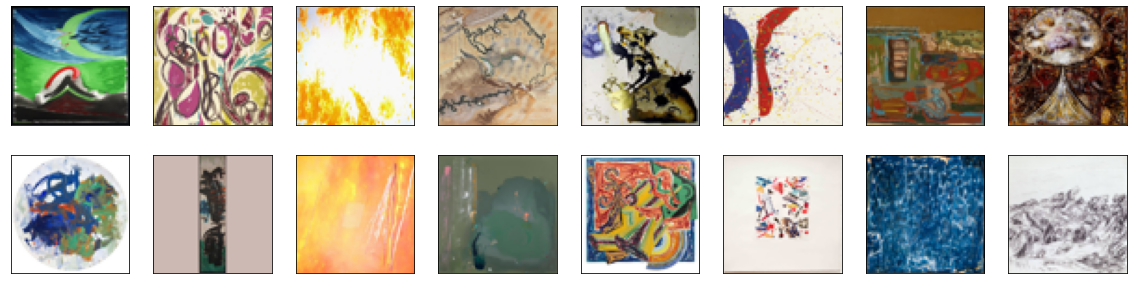

In [5]:
#Mostrando algumas imagens

f, pos = plt.subplots(2, 8, figsize=(20, 5))
for i in range(2):
  for j in range(8):
    index = i*8 + j
    pos[i,j].imshow(np.squeeze(images[index,:,:]))
    pos[i,j].axes.xaxis.set_visible(False)
    pos[i,j].axes.yaxis.set_visible(False)

plt.show()

# Normalizando as Images


In [6]:
images = (images-127.5)/127.5

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import time
from IPython.display import display, clear_output
print(tf.__version__)

2.5.0


In [8]:
BUFFER_SIZE = 32
BATCH_SIZE = 256

# Cria dataset com embaralhamento dos dados e lotes
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#Gerador

In [9]:
# Importa camadas e modelos do keras
from tensorflow.keras import models
from tensorflow.keras import layers

# Define função para criar gerador
def build_generator(z_dim, units):
   
    # Instancia modelo sequencial
    model = models.Sequential()
    
    # Primeira camada densa
    model.add(layers.Dense(16*16*units*8, use_bias=False, input_shape=(z_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Camada para redimensiona a saída da camada densa no formato de matriz
    model.add(layers.Reshape((16, 16, units*8)))

    # 1a camada convolucional transposta
    model.add(layers.Conv2DTranspose(units*2, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 2a camada convolucional transposta
    model.add(layers.Conv2DTranspose(units, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

   # 3a camada convolucional transposta
    model.add(layers.Conv2DTranspose(units, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Camada de saída (Cores)
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', activation='tanh'))

    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 131072)            13107200  
_________________________________________________________________
batch_normalization (BatchNo (None, 131072)            524288    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 131072)            0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       1638400   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0

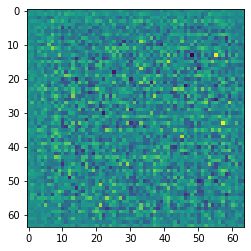

In [10]:
# Chama função para criar o gerador
generator = build_generator(z_dim=100, units=64)

# Mostra sumário do gerador
generator.summary()

# Cria vetor de ruído com disctribuição normal
noise = tf.random.normal([1, 100])

# Gera imagem a partir do vetor de ruído
generated_image = generator(noise, training=False)

# Mostra imagem gerada
plt.imshow(generated_image[0, :, :, 0])
plt.show()

#Discriminador

In [11]:
# Define função que configura discriminador
def build_discriminator(img_dim, units): 
    
    # Instancia modelo sequencial
    model = tf.keras.Sequential()
    
    # 1a camada convolucional
    model.add(layers.Conv2D(units, (5, 5), strides=(2, 2), padding='same', input_shape=[img_dim, img_dim, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # 2a Camada convolucional
    model.add(layers.Conv2D(units*2, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 3a Camada convolucional
    model.add(layers.Conv2D(units*2, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 4a Camada convolucional
    model.add(layers.Conv2D(units*2, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))


    # 5a Camada convolucional
    model.add(layers.Conv2D(units*2, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 6a Camada convolucional
    model.add(layers.Conv2D(units*2, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))


    # Camada de Faltten para adequar saída da camada convolucional para a entrada da camada densa
    model.add(layers.Flatten())
    
    # Camada densa com 1 única saída
    model.add(layers.Dense(1))

    return model

In [12]:
# Chama função para criar discriminador
discriminator = build_discriminator(img_dim=64, units=64)

# Mostra sumário do discriminador
discriminator.summary()

# Calcula previsão do discriminador para a imagem gerada pelo gerador 
decision = discriminator(generated_image)

# Apresenta resultado
print('\nSaída do discriminador:', decision.numpy())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)        

In [13]:
# Instancia objeto com  afunção de custo entropia cruzada binária
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#Funçõoes de Custo

Discriminador

In [14]:
# Define função de custo para o discrminador
def discriminator_loss(real_output, fake_output, y_real, y_fake):
    
    # Custo relacionado às imagens reais
    real_loss = cross_entropy(y_real, real_output)
    
    # Custo relacionado às imagens falsas 
    fake_loss = cross_entropy(y_fake, fake_output)
    
    # Custo total
    total_loss = (real_loss + fake_loss)/2.0
    
    return total_loss

Gerador

In [15]:
# função de custo do gerador
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#Otimizadores

In [16]:
# Taxa de aprendizado
LR = 1.0e-04

# Otimizador no gerador
generator_optimizer = tf.keras.optimizers.Adam(lr=LR, beta_1=0.5)

# otimizador do discrminador
discriminator_optimizer = tf.keras.optimizers.Adam(lr=LR)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# Diretório para Salvar o Modelo

In [17]:
# Define diretório onde salvar o modelo
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Define callback para salvar modelo
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Ciclo de Treinamento

In [18]:
# Número de épocas de treinamento
N_EPOCHS = 160

# Dimensão do vetor de ruído
Z_DIM = 100

# Número de neurônios básico
UNITS = 64

# Dimensão do vetor de imagens
IMG_DIM = 64

In [19]:
# Cria gerador
generator = build_generator(z_dim=Z_DIM, units=UNITS)
print('Configuração do gerador')
generator.summary()

# Cria discriminador
discriminator = build_discriminator(img_dim=IMG_DIM, units=UNITS)
print('\nConfiguração do discriminador')
discriminator.summary()

Configuração do gerador
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 131072)            13107200  
_________________________________________________________________
batch_normalization_4 (Batch (None, 131072)            524288    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 131072)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 16, 16, 128)       1638400   
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (

# Atualização dos parâmetros em uma época

In [20]:
# Observe que o uso da decoração @tf.function, faz com que essa função seja compilada 
# antes de ser executada para aumentar a velocidade de processamento`
@tf.function
def train_step(images):

     # Define tamanho do lote
    batch_size = len(images)

    # Cria lote de vetor de ruídos
    noise = tf.random.normal([batch_size, Z_DIM])
    tf.ones([3, 4], tf.int32)

    # Cria classes reais e falsas desejadas com suavização
    y_real = tf.ones([batch_size], dtype=tf.float32) + 0.2*tf.random.uniform(shape=[batch_size], minval=-1, maxval=1)
    y_fake = tf.zeros([batch_size], dtype=tf.float32) + 0.2*tf.random.uniform(shape=[batch_size], minval=0, maxval=1)

    # Calcula gradientes das funções de custo
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Produz imagens falsas com o gerador
        generated_images = generator(noise, training=True)

        # Classifica imagens reais usando o discriminador
        real_output = discriminator(images, training=True)
        
        # Classifica imagens falsas usando o discriminador
        fake_output = discriminator(generated_images, training=True)

        # Calcula função de custo do gerador        
        gen_loss = generator_loss(fake_output)
        
        # Calcula função de custo do discriminador        
        disc_loss = discriminator_loss(real_output, fake_output, y_real, y_fake)
        
    # Calcula gradiente da função de custo do gerador         
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    # Calcula gradiente da função de custo do discriminadorr 
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Aplica gradiente da função de custo do gerador para atualizar os seus parâmetros  
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    # Aplica gradiente da função de custo do discriminador para atualizar os seus parâmetros  
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Visualização das imagens durante o treinamento

In [21]:
def generate_images(generator, discriminator, imgs_real):    
    # Gera vetor de ruído
    noise = tf.random.normal([8, Z_DIM])

    # Gera imagens falsas usando o gerador com o lote de vetor de ruído 
    imgs_fake = generator.predict(noise)
    imgs_fake = 255*(imgs_fake + 1.0)

    # Mostra imagens reais e falsas e classificação do discriminador
    for image in [imgs_fake, imgs_real]:
        plt.figure(figsize=(8*2, 2))
        for i in range(8):
            # Prevê classificação do discriminador
            disc_score = float(discriminator.predict(np.expand_dims(image[i], axis=0))[0])

            # Mostra as imagens         
            plt.subplot(1, 8, i+1)
            plt.title(str(round(disc_score, 2)))
            plt.imshow(np.squeeze(image[i]), cmap='gray')
            plt.axis('off')
        plt.show()  

# Loop de Treino

Epóca: 159


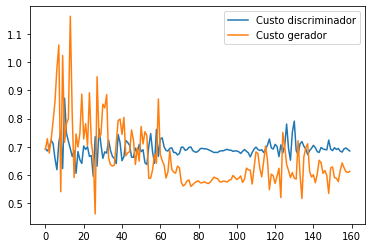

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


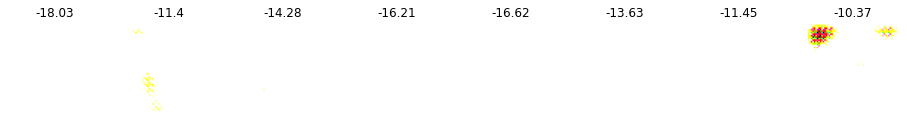

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


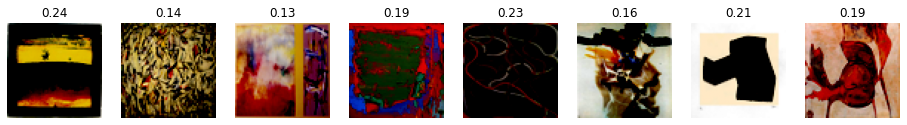

Tempo para época 160: 251.02543020248413 sec - Custo gerador: 0.6133812 Custo discriminador: 0.68562907


In [22]:
# Inicializa lista de custos para cada época
avg_disc_loss = []
avg_gen_loss = []

# Treinamento com N_EPOCHS
for epoch in range(N_EPOCHS):
    start = time.time()

    # Inciailiza lsita de valores das funações de custo
    gen_loss = []
    disc_loss = []
    
    # Aplica gradientes par atualizar parâmetros usando a função train_step
    for image_batch in train_dataset:
        gen_loss_batch, disc_loss_batch = train_step(image_batch)
        
        # Salva valores das funções de custo
        gen_loss.append(gen_loss_batch)
        disc_loss.append(disc_loss_batch)
        
    
    # Apresenta resultados de cada época
    clear_output(True)
    print('Epóca:', epoch)
    avg_disc_loss.append(np.mean(disc_loss))
    avg_gen_loss.append(np.mean(gen_loss))
    plt.plot(range(len(avg_disc_loss)), avg_disc_loss)
    plt.plot(range(len(avg_gen_loss)), avg_gen_loss)
    plt.legend(['Custo discriminador', 'Custo gerador'])
    plt.show()

    # Produz images para visualização
    generate_images(generator, discriminator, image_batch)   
    
    # Salva o modelo a cada 10 epocas
    if (epoch + 1) % 10 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    # Apresenta resultados parciais
    print ('Tempo para época {}: {} sec'.format(epoch + 1, time.time()-start), '-', 'Custo gerador:', np.mean(gen_loss), 'Custo discriminador:', np.mean(disc_loss))

# 1) Criação de imagens novas originais por meio da combinação da representação latente de duas imagens. Nessa etapa crie várias transições entre duas imagens do conjunto de dados, iniciando de uma delas até obter a outra. Faça isso para pelo menos 8 pares de imagens do conjunto de dados.

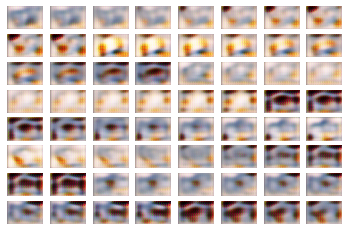

In [23]:
# example of interpolating between generated faces
from numpy import asarray
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from keras.models import load_model
from matplotlib import pyplot
from PIL import Image
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
  
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  
  # reshape into a batch of inputs for the network
  z_input = x_input.reshape(n_samples, latent_dim)
  return z_input
 
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
  
  # interpolate ratios between the points
  ratios = linspace(0, 1, num=n_steps)
  
  # linear interpolate vectors
  vectors = list()
  for ratio in ratios:
	  v = (1.0 - ratio) * p1 + ratio * p2
	  vectors.append(v)
  return asarray(vectors)
 
# create a plot of generated images
def plot_generated(examples, n):
  
  # plot images
  for i in range(n * n):
  
    # define subplot
    pyplot.subplot(n, n, 1 + i)
  
    # turn off axis
    pyplot.axis('off')
  
    # plot raw pixel data
    pyplot.imshow(examples[i, :, :], aspect='auto')
  pyplot.savefig('result.jpg')
  #pyplot.show()
 

# generate points in latent space
n = 20
pts = generate_latent_points(100, n)

# interpolate pairs
results = None
for i in range(0, n, 2):
	
  # interpolate points in latent space
	interpolated = interpolate_points(pts[i], pts[i+1])
	
  # generate images
	X = generator.predict(interpolated)
	
  # scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	if results is None:
		results = X
	else:
		results = vstack((results, X))

# plot the result
plot_generated(results, 8)

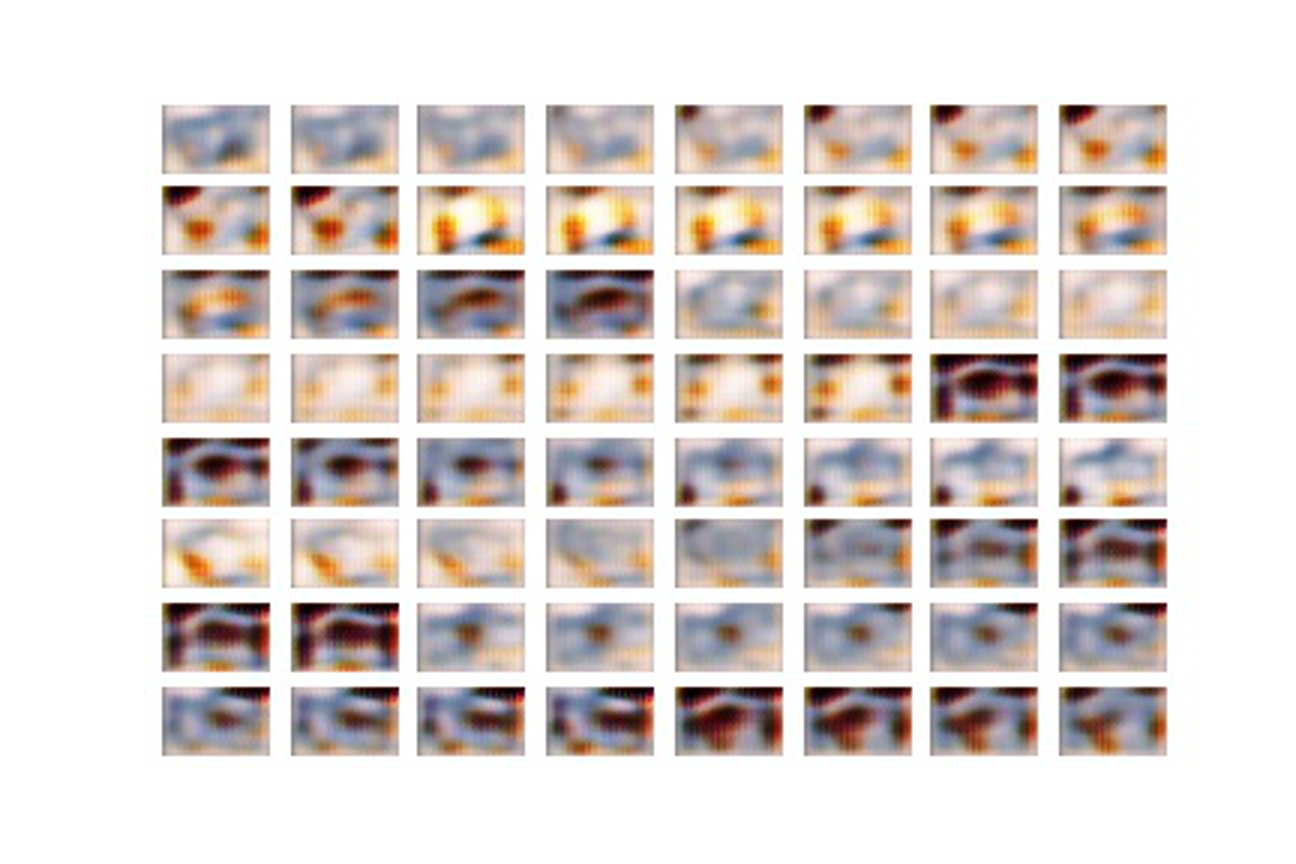

In [24]:
im = Image.open('result.jpg') 

width, height = im.size

im1 = im.resize((width*3,height*3))
im1

# 2) Criação de imagens novas originais a partir de vetores de ruídos. Criei pelo menos 16  imagens.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

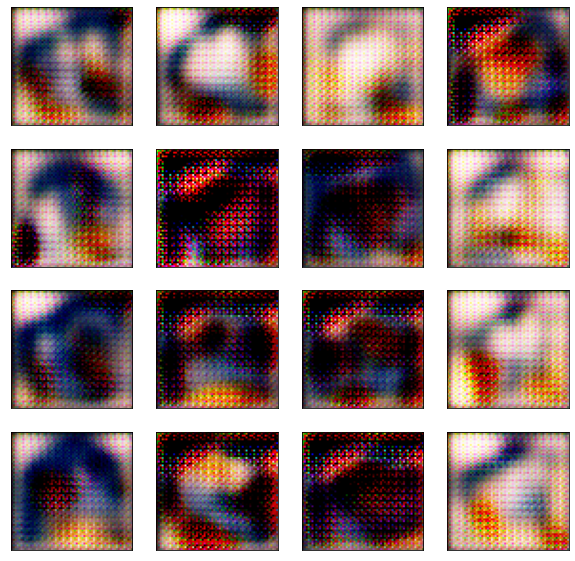

In [25]:
fig, axs = plt.subplots(4, 4, figsize=(10,10))
index = 0
for i in range(4):
  for j in range(4):
    noise = np.random.randn(1, Z_DIM)
    img_gen = generator.predict(noise)[0]

    axs[i,j].imshow(img_gen, aspect='auto' )
    axs[i,j].axes.xaxis.set_visible(False)
    axs[i,j].axes.yaxis.set_visible(False)


    index += 1
plt.show()